# Train the Models for some/all your datasets

### First just run the cell below, it should hopefully complete without error (expect some Warnings from TF)

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


#load some packages in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random as python_random
from numba import njit
from tensorboard.plugins.hparams import api as hp
from stemutils.io import Path
import hyperspy.api as hs
import concurrent.futures
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from functools import lru_cache
from stemseg.processing_funcs import *

#set some variables
print('Using TensorFlow v%s' % tf.__version__)
plt.style.use('default')


#define some functions

###################################################
########### Data Preprocessing ####################
###################################################

def batch_resize(d, bs=512):
    if len(d.shape) == 4:
        flat_d = flatten_nav(d)
    else:
        flat_d = d
    n_batches = int(np.ceil(flat_d.shape[0]//bs))
    batches = [flat_d[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    if len(batches[-1])==0:
        batches.pop(-1)
    print(len(batches[-1]))
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as exe:
        res = [exe.submit(resize, batch, (batch.shape[0],128,128)) for batch in batches]
    r_batches = [f.result() for f in res]
    return np.concatenate(r_batches, axis = 0).reshape((d.shape[0],128,128))

def data_manip(d, bs = 512):
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


def data_manip_lowq(d, central_box = 128):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 
    
    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


###################################################
###################################################
###################################################

def flatten_nav(sig):
    shape = [sig.shape[0]*sig.shape[1]]
    for i in sig.shape[2:]:
        shape.append(i)
    return sig.reshape(shape)


class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames,  batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        out_img = np.asarray([np.load(file_name)[:,:,None] for file_name in batch_x])
        return out_img, out_img
        #return batch_x, batch_y
        
        
class Array_Generator(keras.utils.Sequence) :
    def __init__(self, images,  batch_size, target = 'same') :
        self.images = images
        self.batch_size = batch_size
        if target == 'same':
            self.target = images
        else:
            self.target = target

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        out_img = self.images[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        out_targ = self.target[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        return out_img, out_targ
        #return batch_x, batch_y

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_vae_model(hparams):
    
    n_img = 128
    latent_dim = hparams['LAT']
    beta = hparams['B']

    image_input = keras.Input(shape=(n_img, n_img,1), name = 'enc_input')
    x = layers.Conv2D(hparams['KN1'],5, strides = 2, activation='relu',padding='same', input_shape=image_input.shape, name = 'enc_conv1')(image_input)
    x = layers.Conv2D(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv2')(x)
    x = layers.Conv2D(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv3')(x)
    x = layers.Conv2D(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv4')(x)
    x = layers.Conv2D(hparams['KN5'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv5')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(hparams['D1'], activation='relu', name = 'enc_d1')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d2_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d3_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d4_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d5_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d6_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d7_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d8_t')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean_t")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var_t")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

    z_input = keras.Input(shape=(latent_dim,), name = 'dec_input_t')
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d1_t')(z_input)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d2')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d3')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d4')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d5')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d6')(x)
    x = layers.Dense(hparams['D1'], activation="relu", name = 'dec_d7')(x)
    x = layers.Dense(4*4*hparams['KN5'], activation="relu", name = 'dec_d8')(x)
    x = layers.Reshape((4, 4,hparams['KN5']))(x)
    x = layers.Conv2DTranspose(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv1')(x)
    x = layers.Conv2DTranspose(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv2')(x)
    x = layers.Conv2DTranspose(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv3')(x)
    x = layers.Conv2DTranspose(hparams['KN1'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv4')(x)
    image_output = layers.Conv2DTranspose(1,5, strides = 2, activation='sigmoid',padding='same', name = 'dec_conv5')(x)
    #image_output = layers.Conv2DTranspose(16,3, strides = 2, activation='sigmoid',padding='same')
    #image_output = layers.Reshape((n_img, n_img,1))(x)
    decoder_VAE = keras.Model(z_input, image_output)

    # VAE class
    class VAE(keras.Model):
        # constructor
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        # customise train_step() to implement the loss 
        def train_step(self, x):
            if isinstance(x, tuple):
                x = x[0]
            with tf.GradientTape() as tape:
                # encoding
                z_mean, z_log_var, z = self.encoder(x)
                # decoding
                x_prime = self.decoder(z)
                # reconstruction error by binary crossentropy loss
                reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * n_img * n_img
                # KL divergence
                kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                # loss = reconstruction error + KL divergence
                loss = reconstruction_loss + beta* kl_loss
            # apply gradient
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            # return loss for metrics log
            return {"loss": loss}


        def call(self, x):
            if isinstance(x, tuple):
                x = x[0]
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            return x_prime
    # build the VAE
    vae_model = VAE(encoder_VAE, decoder_VAE)

    # compile the VAE
    vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hparams['LR']),loss=custom_loss)
    vae_model.build((1,128,128,1))
    
    return vae_model



def custom_loss(x,y):
    n_img = 128
    return tf.reduce_mean(keras.losses.binary_crossentropy(x, y)) * n_img * n_img


2022-04-04 13:00:47.184274: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


Using TensorFlow v2.3.0
Using TensorFlow v2.3.0


### Now check that you can find the GPU

In [2]:
tf.config.list_physical_devices()

2022-04-04 13:01:19.015586: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-04-04 13:01:19.016643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-04-04 13:01:19.016671: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-04 13:01:19.019765: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-04 13:01:19.022278: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-04-04 13:01:19.023654: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2022-04-04 13:01:19.026469: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusolv

# Training a Single Dataset

### Either enter the path directly to the dp variable or use the index from the list above

In [3]:
#Either
dp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/20210925_152115_data.hdf5')

### Create a directory to save our intermediate model checkpoints 

In [4]:
mp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel')
if not mp.exists():
    mp.mkdir()
print(mp)

/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel


### Load in the Data

In [5]:
sample = ProcessedSample(dp, 'Test')

### Create a dictionary to hold some useful information

In [6]:
info = {}

In [7]:
nds = flatten_nav(sample.raw_data.data)

In [8]:
nds.shape

(65025, 476, 476)

In [9]:
ds = hs.load(dp)

In [10]:
sx, sy = ds.data.shape[2:]

<IPython.core.display.Javascript object>


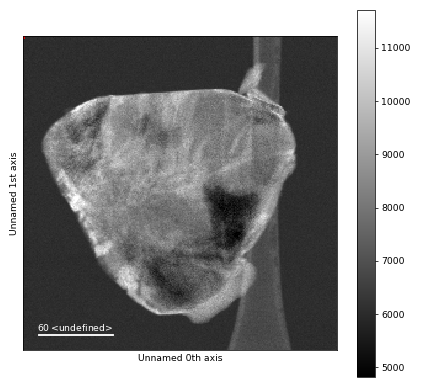

<IPython.core.display.Javascript object>


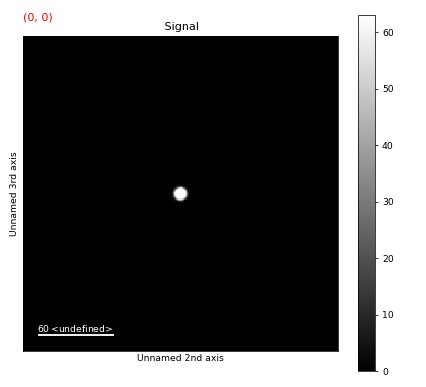

In [11]:
ds.isig[sx//2-128:sx//2+128, sy//2-128:sy//2+128].plot()

In [12]:
from skimage.measure import shannon_entropy

entropy = np.zeros((sample.raw_data.data.shape[0:2]))

for i in range(ds.data.shape[0]):
    print(i)
    for j in range(ds.data.shape[1]):
        entropy[i,j] = shannon_entropy(ds.data[i,j,sx//2-128:sx//2+128, sy//2-128:sy//2+128])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254


In [13]:
data_patterns = flatten_nav(ds.data)

In [14]:
entr = flatten_nav(entropy**10)

In [15]:
sl_pdf = entr/ entr.sum()

<IPython.core.display.Javascript object>


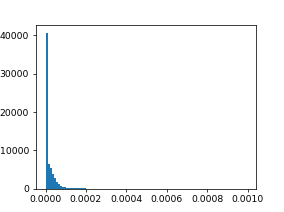

(array([4.0744e+04, 6.4760e+03, 5.4650e+03, 3.8390e+03, 2.7030e+03,
        1.7230e+03, 1.1660e+03, 7.7900e+02, 5.2900e+02, 3.4700e+02,
        2.7400e+02, 1.8500e+02, 1.6100e+02, 1.1900e+02, 7.6000e+01,
        6.9000e+01, 4.7000e+01, 5.3000e+01, 3.9000e+01, 2.8000e+01,
        2.1000e+01, 2.0000e+01, 1.7000e+01, 1.0000e+01, 1.7000e+01,
        1.3000e+01, 6.0000e+00, 1.1000e+01, 6.0000e+00, 8.0000e+00,
        4.0000e+00, 4.0000e+00, 6.0000e+00, 8.0000e+00, 4.0000e+00,
        9.0000e+00, 1.0000e+00, 6.0000e+00, 2.0000e+00, 4.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 5.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

In [16]:
plt.figure()
plt.hist(sl_pdf,100)

In [17]:
choice_loc = np.zeros(data_patterns.shape[0])
for choice in np.random.choice(np.arange(data_patterns.shape[0]), 50000, True, sl_pdf):
    choice_loc[choice] += 1

<IPython.core.display.Javascript object>


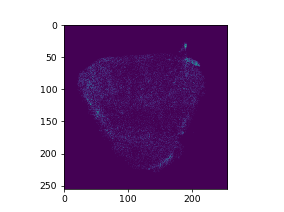

In [18]:
plt.figure()
plt.imshow(choice_loc.reshape(ds.data.shape[0:2]), interpolation='nearest')

In [19]:
nldps = []
for i in range(10):
    sdps = hs.signals.Signal2D(data_patterns[np.random.choice(np.arange(data_patterns.shape[0]), 5000, True, sl_pdf)])
    nldps.append(sdps.data)
nlds = flatten_nav(np.asarray(nldps))

In [20]:
def data_manip_lowq_resized(d, central_box = 256, bs = 256):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 
    
    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 

In [21]:
input_data = data_manip_lowq_resized(nlds)
#np.random.shuffle(input_data)
#input_targets = data_manip_lowq(nlds)
val_data = data_manip_lowq_resized(nlds[::10])
np.random.shuffle(val_data)


started data manipulations
resized
80
started data manipulations
resized
136


<IPython.core.display.Javascript object>


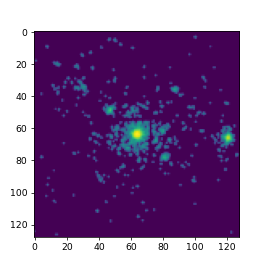

In [22]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])
#plt.figure(figsize = (4,4))
#plt.imshow(input_targets[rand_patt])

##### Otherwise just skip

In [23]:
print(input_data.shape)

(50000, 128, 128)


In [24]:
batch_size = 2048

train_gen = Array_Generator(input_data, batch_size)#, target = input_targets)
valid_gen = Array_Generator(val_data, batch_size)

batch_shape = train_gen[0][0].shape
input_shape = (batch_shape[1],batch_shape[2],batch_shape[3])
out_dims = int(train_gen[0][1].shape[1])

### Check the training data

<IPython.core.display.Javascript object>


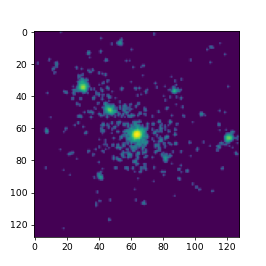

In [25]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])

### Set the checkpointing

In [26]:
chkpoint_filepath = str(mp)+'/chk-{epoch:02d}-{val_loss:.5e}.hdf5'
chkpoint_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = chkpoint_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    options=None)

### Redefine the model parameters if you want

In [27]:
rebin_factor = 1

In [28]:
sample_name = 'full'
hparams= {'KN1':32,'KN2':64,'KN3':128, 'KN4':128, 'KN5':256,'D1':128,'D2':512,'LAT':2,'LR':0.0001, 'B':1}

vae_model = create_vae_model(hparams)
info[sample_name] = {'rebin': rebin_factor, 'hparams':hparams}

2022-04-04 13:03:43.133076: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-04 13:03:43.143604: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400000000 Hz
2022-04-04 13:03:43.147742: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5573bdb74e10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-04 13:03:43.147771: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-04-04 13:03:43.247598: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5573bdbe1780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-04-04 13:03:43.

### Will be helpful to start with a trained model so set one here (otherwise will just take longer)

In [29]:
old_model ='/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-277-1.57610e+03.hdf5'

In [30]:
vae_model.load_weights(old_model)

### Train the Model

In [31]:
history = vae_model.fit(train_gen, validation_data=valid_gen, epochs=10000, callbacks= [chkpoint_model])

Epoch 1/10000


2022-04-04 13:03:46.358046: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-04 13:03:46.604579: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-04-04 13:03:47.654019: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-04-04 13:03:47.770521: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


25/25 [==============================] - ETA: 0s - loss: 1659.1816
Epoch 00001: val_loss improved from inf to 1600.68884, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-01-1.60069e+03.hdf5
25/25 [==============================] - 43s 2s/step - loss: 1657.0301 - val_loss: 1600.6888
Epoch 2/10000
25/25 [==============================] - ETA: 0s - loss: 1593.0897
Epoch 00002: val_loss improved from 1600.68884 to 1583.22266, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-02-1.58322e+03.hdf5
25/25 [==============================] - 14s 542ms/step - loss: 1593.0399 - val_loss: 1583.2227
Epoch 3/10000
25/25 [==============================] - ETA: 0s - loss: 1584.1112
Epoch 00003: val_loss improved from 1583.22266 to 1578.80005, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-03-1.57880e+03.hdf5
25/25 [===

Epoch 31/10000
25/25 [==============================] - ETA: 0s - loss: 1579.1499
Epoch 00031: val_loss did not improve from 1574.77100
25/25 [==============================] - 13s 535ms/step - loss: 1579.2981 - val_loss: 1575.4441
Epoch 32/10000
25/25 [==============================] - ETA: 0s - loss: 1578.8705
Epoch 00032: val_loss did not improve from 1574.77100
25/25 [==============================] - 13s 539ms/step - loss: 1578.9224 - val_loss: 1574.9214
Epoch 33/10000
25/25 [==============================] - ETA: 0s - loss: 1578.6015
Epoch 00033: val_loss did not improve from 1574.77100
25/25 [==============================] - 14s 543ms/step - loss: 1578.7003 - val_loss: 1575.6288
Epoch 34/10000
25/25 [==============================] - ETA: 0s - loss: 1578.8575
Epoch 00034: val_loss did not improve from 1574.77100
25/25 [==============================] - 13s 537ms/step - loss: 1578.8477 - val_loss: 1574.9429
Epoch 35/10000
25/25 [==============================] - ETA: 0s - loss: 

Epoch 65/10000
25/25 [==============================] - ETA: 0s - loss: 1577.5252
Epoch 00065: val_loss improved from 1574.56604 to 1573.74719, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-65-1.57375e+03.hdf5
25/25 [==============================] - 13s 538ms/step - loss: 1577.6593 - val_loss: 1573.7472
Epoch 66/10000
25/25 [==============================] - ETA: 0s - loss: 1577.6115
Epoch 00066: val_loss did not improve from 1573.74719
25/25 [==============================] - 13s 532ms/step - loss: 1577.7311 - val_loss: 1574.3489
Epoch 67/10000
25/25 [==============================] - ETA: 0s - loss: 1577.7279
Epoch 00067: val_loss improved from 1573.74719 to 1573.59973, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-67-1.57360e+03.hdf5
25/25 [==============================] - 13s 537ms/step - loss: 1577.5432 - val_loss: 1573.5997
Epoch 68/10000
25/25 [====

Epoch 98/10000
25/25 [==============================] - ETA: 0s - loss: 1577.1902
Epoch 00098: val_loss improved from 1572.74878 to 1572.72461, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-98-1.57272e+03.hdf5
25/25 [==============================] - 14s 541ms/step - loss: 1577.2800 - val_loss: 1572.7246
Epoch 99/10000
25/25 [==============================] - ETA: 0s - loss: 1577.1421
Epoch 00099: val_loss did not improve from 1572.72461
25/25 [==============================] - 13s 538ms/step - loss: 1576.9386 - val_loss: 1572.7676
Epoch 100/10000
25/25 [==============================] - ETA: 0s - loss: 1576.4925
Epoch 00100: val_loss improved from 1572.72461 to 1572.40210, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-100-1.57240e+03.hdf5
25/25 [==============================] - 14s 543ms/step - loss: 1576.5315 - val_loss: 1572.4021
Epoch 101/10000
25/25 [=

Epoch 129/10000
25/25 [==============================] - ETA: 0s - loss: 1575.4894
Epoch 00129: val_loss did not improve from 1571.48816
25/25 [==============================] - 13s 532ms/step - loss: 1575.4381 - val_loss: 1571.7512
Epoch 130/10000
25/25 [==============================] - ETA: 0s - loss: 1576.7399
Epoch 00130: val_loss did not improve from 1571.48816
25/25 [==============================] - 13s 535ms/step - loss: 1576.6597 - val_loss: 1572.5607
Epoch 131/10000
25/25 [==============================] - ETA: 0s - loss: 1575.9483
Epoch 00131: val_loss improved from 1571.48816 to 1571.37561, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-131-1.57138e+03.hdf5
25/25 [==============================] - 13s 539ms/step - loss: 1575.7715 - val_loss: 1571.3756
Epoch 132/10000
25/25 [==============================] - ETA: 0s - loss: 1577.0045
Epoch 00132: val_loss did not improve from 1571.37561
25/25 [=================

Epoch 162/10000
25/25 [==============================] - ETA: 0s - loss: 1574.7707
Epoch 00162: val_loss did not improve from 1570.60486
25/25 [==============================] - 13s 530ms/step - loss: 1574.8147 - val_loss: 1574.4792
Epoch 163/10000
25/25 [==============================] - ETA: 0s - loss: 1575.6050
Epoch 00163: val_loss did not improve from 1570.60486
25/25 [==============================] - 13s 530ms/step - loss: 1575.4046 - val_loss: 1571.0817
Epoch 164/10000
25/25 [==============================] - ETA: 0s - loss: 1575.4038
Epoch 00164: val_loss did not improve from 1570.60486
25/25 [==============================] - 13s 531ms/step - loss: 1575.3273 - val_loss: 1574.0565
Epoch 165/10000
25/25 [==============================] - ETA: 0s - loss: 1574.5255
Epoch 00165: val_loss did not improve from 1570.60486
25/25 [==============================] - 13s 530ms/step - loss: 1574.1345 - val_loss: 1570.6285
Epoch 166/10000
25/25 [==============================] - ETA: 0s - l

Epoch 196/10000
25/25 [==============================] - ETA: 0s - loss: 1573.6168
Epoch 00196: val_loss did not improve from 1569.65308
25/25 [==============================] - 13s 531ms/step - loss: 1573.5732 - val_loss: 1570.1887
Epoch 197/10000
25/25 [==============================] - ETA: 0s - loss: 1573.6443
Epoch 00197: val_loss did not improve from 1569.65308
25/25 [==============================] - 13s 532ms/step - loss: 1573.5148 - val_loss: 1569.7159
Epoch 198/10000
25/25 [==============================] - ETA: 0s - loss: 1573.6460
Epoch 00198: val_loss did not improve from 1569.65308
25/25 [==============================] - 13s 532ms/step - loss: 1573.8198 - val_loss: 1569.9122
Epoch 199/10000
25/25 [==============================] - ETA: 0s - loss: 1574.3756
Epoch 00199: val_loss did not improve from 1569.65308
25/25 [==============================] - 13s 531ms/step - loss: 1574.3991 - val_loss: 1569.9742
Epoch 200/10000
25/25 [==============================] - ETA: 0s - l

Epoch 229/10000
25/25 [==============================] - ETA: 0s - loss: 1572.4892
Epoch 00229: val_loss did not improve from 1568.43274
25/25 [==============================] - 13s 534ms/step - loss: 1572.5759 - val_loss: 1568.5668
Epoch 230/10000
25/25 [==============================] - ETA: 0s - loss: 1572.3271
Epoch 00230: val_loss improved from 1568.43274 to 1568.36877, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-230-1.56837e+03.hdf5
25/25 [==============================] - 13s 538ms/step - loss: 1572.2639 - val_loss: 1568.3688
Epoch 231/10000
25/25 [==============================] - ETA: 0s - loss: 1573.1168
Epoch 00231: val_loss did not improve from 1568.36877
25/25 [==============================] - 13s 531ms/step - loss: 1572.9144 - val_loss: 1568.7114
Epoch 232/10000
25/25 [==============================] - ETA: 0s - loss: 1573.3933
Epoch 00232: val_loss did not improve from 1568.36877
25/25 [=================

Epoch 263/10000
25/25 [==============================] - ETA: 0s - loss: 1571.9040
Epoch 00263: val_loss did not improve from 1568.08936
25/25 [==============================] - 13s 531ms/step - loss: 1572.0024 - val_loss: 1569.0178
Epoch 264/10000
25/25 [==============================] - ETA: 0s - loss: 1573.0823
Epoch 00264: val_loss did not improve from 1568.08936
25/25 [==============================] - 13s 532ms/step - loss: 1573.1825 - val_loss: 1568.4430
Epoch 265/10000
25/25 [==============================] - ETA: 0s - loss: 1572.8559
Epoch 00265: val_loss did not improve from 1568.08936
25/25 [==============================] - 13s 531ms/step - loss: 1572.4517 - val_loss: 1568.1698
Epoch 266/10000
25/25 [==============================] - ETA: 0s - loss: 1572.0633
Epoch 00266: val_loss improved from 1568.08936 to 1567.88147, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-266-1.56788e+03.hdf5
25/25 [=================

Epoch 296/10000
25/25 [==============================] - ETA: 0s - loss: 1571.6047
Epoch 00296: val_loss did not improve from 1567.39539
25/25 [==============================] - 13s 534ms/step - loss: 1571.4660 - val_loss: 1567.9822
Epoch 297/10000
25/25 [==============================] - ETA: 0s - loss: 1572.5303
Epoch 00297: val_loss did not improve from 1567.39539
25/25 [==============================] - 13s 537ms/step - loss: 1572.5509 - val_loss: 1567.7552
Epoch 298/10000
25/25 [==============================] - ETA: 0s - loss: 1572.2323
Epoch 00298: val_loss did not improve from 1567.39539
25/25 [==============================] - 13s 540ms/step - loss: 1572.0394 - val_loss: 1568.3209
Epoch 299/10000
25/25 [==============================] - ETA: 0s - loss: 1571.9148
Epoch 00299: val_loss did not improve from 1567.39539
25/25 [==============================] - 14s 543ms/step - loss: 1571.7086 - val_loss: 1567.6797
Epoch 300/10000
25/25 [==============================] - ETA: 0s - l

Epoch 330/10000
25/25 [==============================] - ETA: 0s - loss: 1571.4060
Epoch 00330: val_loss did not improve from 1566.88721
25/25 [==============================] - 13s 531ms/step - loss: 1571.4111 - val_loss: 1568.5496
Epoch 331/10000
25/25 [==============================] - ETA: 0s - loss: 1571.6916
Epoch 00331: val_loss did not improve from 1566.88721
25/25 [==============================] - 13s 530ms/step - loss: 1571.6739 - val_loss: 1569.0511
Epoch 332/10000
25/25 [==============================] - ETA: 0s - loss: 1571.5574
Epoch 00332: val_loss did not improve from 1566.88721
25/25 [==============================] - 13s 531ms/step - loss: 1571.7191 - val_loss: 1567.4360
Epoch 333/10000
25/25 [==============================] - ETA: 0s - loss: 1571.0554
Epoch 00333: val_loss did not improve from 1566.88721
25/25 [==============================] - 13s 531ms/step - loss: 1571.1890 - val_loss: 1568.9838
Epoch 334/10000
25/25 [==============================] - ETA: 0s - l

Epoch 363/10000
25/25 [==============================] - ETA: 0s - loss: 1570.4173
Epoch 00363: val_loss did not improve from 1566.12231
25/25 [==============================] - 13s 532ms/step - loss: 1570.6102 - val_loss: 1567.5266
Epoch 364/10000
25/25 [==============================] - ETA: 0s - loss: 1570.6843
Epoch 00364: val_loss did not improve from 1566.12231
25/25 [==============================] - 13s 531ms/step - loss: 1570.8007 - val_loss: 1568.5800
Epoch 365/10000
25/25 [==============================] - ETA: 0s - loss: 1570.5417
Epoch 00365: val_loss did not improve from 1566.12231
25/25 [==============================] - 13s 534ms/step - loss: 1570.3421 - val_loss: 1566.5293
Epoch 366/10000
25/25 [==============================] - ETA: 0s - loss: 1570.4676
Epoch 00366: val_loss did not improve from 1566.12231
25/25 [==============================] - 13s 540ms/step - loss: 1570.3376 - val_loss: 1567.6034
Epoch 367/10000
25/25 [==============================] - ETA: 0s - l

Epoch 397/10000
25/25 [==============================] - ETA: 0s - loss: 1569.5905
Epoch 00397: val_loss improved from 1565.69897 to 1565.66138, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-397-1.56566e+03.hdf5
25/25 [==============================] - 13s 538ms/step - loss: 1569.7076 - val_loss: 1565.6614
Epoch 398/10000
25/25 [==============================] - ETA: 0s - loss: 1570.1826
Epoch 00398: val_loss improved from 1565.66138 to 1565.63574, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-398-1.56564e+03.hdf5
25/25 [==============================] - 13s 537ms/step - loss: 1570.4264 - val_loss: 1565.6357
Epoch 399/10000
25/25 [==============================] - ETA: 0s - loss: 1569.8936
Epoch 00399: val_loss did not improve from 1565.63574
25/25 [==============================] - 13s 532ms/step - loss: 1569.7072 - val_loss: 1565.8545
Epoch 400/10000
25/25

25/25 [==============================] - ETA: 0s - loss: 1570.0798
Epoch 00429: val_loss did not improve from 1565.10303
25/25 [==============================] - 13s 532ms/step - loss: 1570.0227 - val_loss: 1566.7509
Epoch 430/10000
25/25 [==============================] - ETA: 0s - loss: 1569.9465
Epoch 00430: val_loss did not improve from 1565.10303
25/25 [==============================] - 13s 532ms/step - loss: 1569.7683 - val_loss: 1565.9031
Epoch 431/10000
25/25 [==============================] - ETA: 0s - loss: 1569.3457
Epoch 00431: val_loss did not improve from 1565.10303
25/25 [==============================] - 13s 536ms/step - loss: 1569.6247 - val_loss: 1566.1984
Epoch 432/10000
25/25 [==============================] - ETA: 0s - loss: 1571.8759
Epoch 00432: val_loss did not improve from 1565.10303
25/25 [==============================] - 13s 534ms/step - loss: 1571.7474 - val_loss: 1567.2300
Epoch 433/10000
25/25 [==============================] - ETA: 0s - loss: 1570.9571
E

Epoch 464/10000
25/25 [==============================] - ETA: 0s - loss: 1571.4084
Epoch 00464: val_loss did not improve from 1564.98096
25/25 [==============================] - 13s 530ms/step - loss: 1571.2848 - val_loss: 1568.3669
Epoch 465/10000
25/25 [==============================] - ETA: 0s - loss: 1570.5749
Epoch 00465: val_loss did not improve from 1564.98096
25/25 [==============================] - 13s 531ms/step - loss: 1570.4994 - val_loss: 1566.5254
Epoch 466/10000
 3/25 [==>...........................] - ETA: 9s - loss: 1569.6254

KeyboardInterrupt: 

In [97]:
vae_model.save_weights('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/ntest.hdf5')